In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
def css_styling():
    styles = """
<style>
.output_png { text-align:  center; }
</style>
    """
    return HTML(styles)
css_styling()

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def runMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m
    if lamb > 0:
        j += lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    if lamb > 0:
        g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def SGD(h, fJ, fdJ, theta, X, Y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        adaGrad=False, logError=False, validate=0.0, valStep=100, lamb=0):
    errorsX, errorsY = [], []
    errorsVX, errorsVY = [], []
    
    XT, YT = X, Y
    if validate > 0:
        mv = int(X.shape[0] * validate)
        XV, YV = X[:mv], Y[:mv] 
        XT, YT = X[mv:], Y[mv:] 
    m, n = XT.shape

    start, end = 0, batchSize
    maxSteps = (m * float(maxEpochs)) / batchSize
    
    if adaGrad:
        hgrad = np.matrix(np.zeros(n)).reshape(n,1)
    
    for i in range(int(maxSteps)):
        XBatch, YBatch =  XT[start:end,:], YT[start:end,:]

        grad = fdJ(h, theta, XBatch, YBatch, lamb=lamb)
        if adaGrad:
            hgrad += np.multiply(grad, grad)
            Gt = 1.0 / (10**-7 + np.sqrt(hgrad))
            theta = theta - np.multiply(alpha * Gt, grad)
        else:
            theta = theta - alpha * grad
        
        if logError:
            errorsX.append(float(i*batchSize)/m)
            errorsY.append(fJ(h, theta, XBatch, YBatch).item())
            if validate > 0 and i % valStep == 0:
                errorsVX.append(float(i*batchSize)/m)
                errorsVY.append(fJ(h, theta, XV, YV).item())
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
    return theta, (errorsX, errorsY, errorsVX, errorsVY)

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

## Wykład 08

# Metodologia testowania

* Metodologia testowania
* Zjawisko przetrenowania
* Urozmaicenie metod

## Część 1. 
# Metodologia testowania

## Zbiór uczący a zbiór testowy

* Na zbiorze uczącym uczymy algorytymy, na zbiorze testowym, sprawdzamy ich poprawność. 
* Typowe stosunki podziału to 80/20 lub 90/10.
* Kontaminacja danych treningowych danymi testowymi jest **poważnym** błędem.
* Zbiór testowy często jest nieznany. 

## Zbiór walidacyjny a zbiór uczący

* Zbiór walidacyjny (*validation set, development set*) często wyodrębniamy z danych treningowych.. 
* Służy do ustalania parametrów i wybóru modelu.

* **Parametry modelu dobieramy na zbiorze walidacyjnym, nigdy nie na zbiorze testowym (nawet i szczególnie, gdy jest dany)!**

* Sytuacja konkursowa, gdzie dozwolona jest pewna liczba zgłoszeń, jest wyjątkiem.

## Walidacja krzyżowa

<img width="100%" src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png"/>
Żródło: https://chrisjmccormick.wordpress.com/2013/07/31/k-fold-cross-validation-with-matlab-code/

## Walidacja krzyżowa

* Podziel dane $D = \left\{ (x^{(1)}, y^{(1)}), \ldots, (x^{(m)}, y^{(m)})\right\} $ na $N$ rozłącznych zbiorów $T_1,\ldots,T_N$
* Dla $i=1,\ldots,N$, wykonaj:
    * Użyj $T_i$ do walidacji i zbiór $S_i$ do trenowania, gdzie $S_i = D \setminus T_i$. 
    * Zapisz model $\theta_i$.
* Akumuluj wyniki dla modeli $\theta_i$ dla zbiorów $T_i$.
* Ustalaj parametry uczenia na akumulowanych wynikach.

## Zasady postępowania

* Zazwyczaj ustala się $N$ w przedziale od $4$ do $10$, tzw. $N$-krotna walidacja krzyżowa (_$N$-fold cross validation_). 
* Zbiór $D$ warto zrandomizować przed podziałem.
* W jaki sposób akumulować wyniki dla wszystkich zbiórow $T_i$?
* Po ustaleniu parametrów dla każdego $T_i$, trenujemy model na całych danych treningowych z ustalonymi parametrami.
* Testujemy na zbiorze testowym (jeśli jest dany).

## Ekstremalna walidacja krzyżowa: <br/>Leave-one-out

Szczególny przypadek walidacji krzyżowej, gdzie $N = m$.

### Dyskusja:

* Jaki jest teraz rozmiar jednego zbioru $T_i$?
* Jakie są zalety i wady tej metody?
* Kiedy metoda jest przydatna?

## Zbiór walidujący a algorytmy optymalizacji

* Gdy błąd rośnie na zbiorze uczącym, mamy źle dobrany parametr $\alpha$. Należy go wtedy zmniejszyć.
* Gdy błąd zmniejsza się na zbiorze trenującym, ale roźnie na zbiorze walidującym, mamy do czynienia ze zjawiskiem **nadmiernego dopasowania** (_overfitting_).
* Należy wtedy przerwać optymalizację. Automatyzacja tego procesu to **early stopping**.

## Część 2. 
# Zjawisko nadmiernego dopasowania i regularyzacja

In [3]:
n = 6

data = np.matrix(np.loadtxt("ex2data2.txt",delimiter=","))
np.random.shuffle(data)

X = powerme(data[:,0], data[:,1], n)
Y = data[:,2]

In [4]:
def draw_regularization_example(lamb=0):
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.scatter(X[:,2].tolist(), X[:,1].tolist(),
                c=Y.tolist(),
                s=100, cmap=plt.cm.get_cmap('prism'));

    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                         logError=True, validate=0.25, valStep=1, lamb=lamb)

    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.02),
                         np.arange(-1.5, 1.5, 0.02))
    l = len(xx.ravel())
    C = powerme(xx.reshape(l,1),yy.reshape(l,1),n)
    z = classifyBi(thetaBest, C).reshape(np.sqrt(l),np.sqrt(l))

    plt.contour(xx, yy, z, levels=[0.5], lw=3);
    plt.ylim(-1,1.2);
    plt.xlim(-1,1.2);
    plt.legend();
    plt.subplot(122)
    plt.plot(err[0],err[1], lw=3, label="Training error")
    plt.plot(err[2],err[3], lw=3, label="Validation error");
    plt.legend()
    plt.ylim(0.2,0.8);

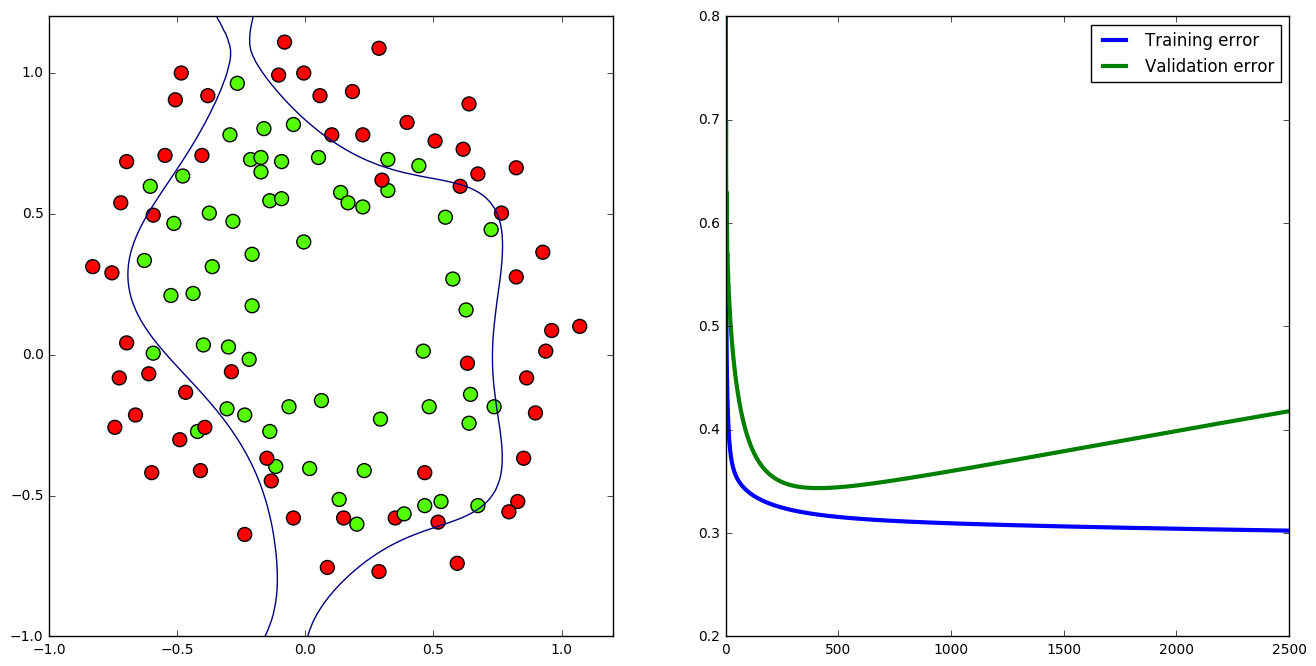

In [5]:
draw_regularization_example()

## Regularyzacja 

* Metoda zapobiegania zjawisku nadmiernego dopasowania (*overfitting*)
* Kara za ekstremalne wartości parametrów $\theta$
* Najbardziej popularne metody to $L_1$ i $L_2$ ($L_p = ||x||^p_p = \sum_{i=0}^n |x_i|^p$)
* $L_1$ nie jest różniczkowalna, w metodach opartach na gradientach stosuje się raczej $L_2$

## Regularyzacja dla regresji logistycznej

* Funkcja kosztu

$$\small
\begin{array}{rl}
J(\theta)=&-\dfrac{1}{m} [\sum_{i=1}^{m} y^{(i)} \log h_\theta(x^{(i)})+ (1-y^{(i)}) \log (1-h_\theta(x^{(i)}))]\\  &\color{red}{+ \dfrac{\lambda}{2m}\sum_{j=1}^{n}\theta^2_j}
\end{array}
$$

* Gradient

$$\small
\begin{array}{llll}
\dfrac{\partial J(\theta)}{\partial \theta_0} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_0 & \textrm{gdy $j = 0$ }\\
\dfrac{\partial J(\theta)}{\partial \theta_j} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j \color{red}{+ \dfrac{\lambda}{m}\theta_j} & \textrm{gdy $j \ge 1 $} \\
\end{array} 
$$

## Implementacja

In [6]:
def J_(h,theta,X,y,lamb=0):
    m = float(len(y))
    f = h(theta, X, eps=10**-7)
    j = 1.0/m \
        * -np.sum(np.multiply(y, np.log(f)) + 
                  np.multiply(1 - y, np.log(1 - f)), axis=0) \
        + lamb/(2*m) * np.sum(np.power(theta[1:] ,2))
    return j

def dJ_(h,theta,X,y,lamb=0):
    m = float(y.shape[0])
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    g[1:] += lamb/m * theta[1:]
    return g

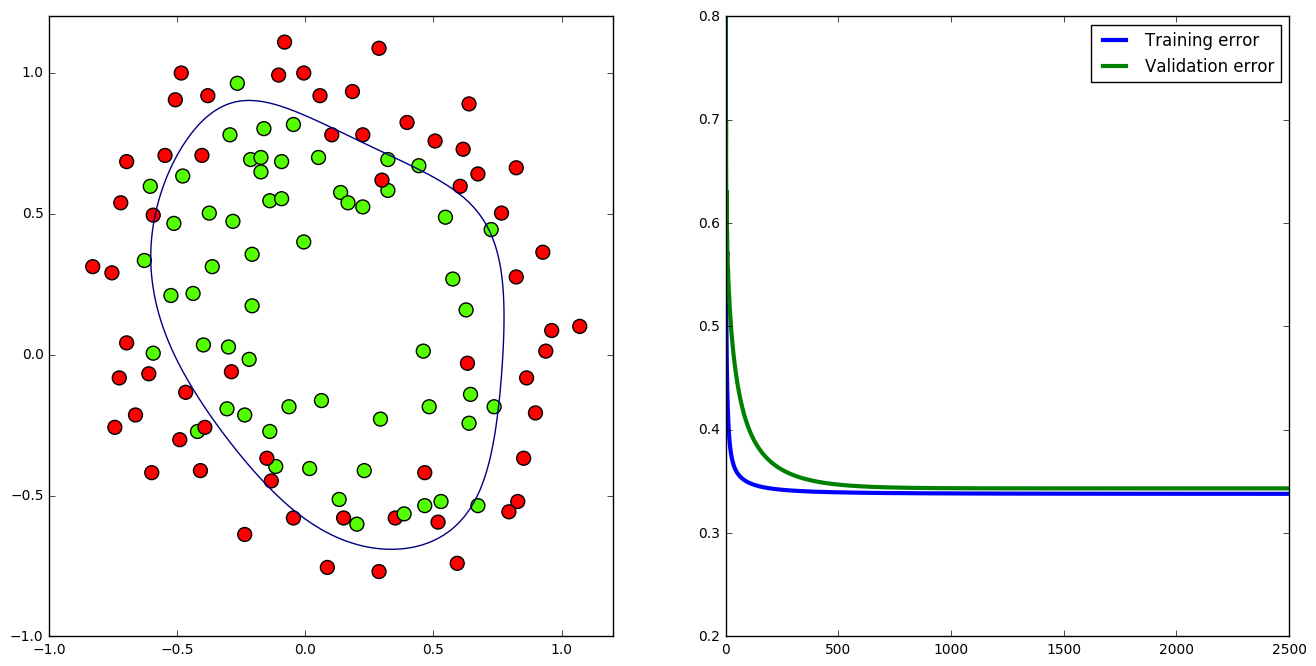

In [7]:
draw_regularization_example(lamb=0.01)

## Różne twarze (nie)dopasowania

<img style="margin:auto" width="90%" src="fit.png"/>

## Bias vs variance

Słabą generalizację można rozpatrywać w kontekście błędu systematycznego i wariancji.

* **Bias** (błąd systematyczny): 
    * Błąd wynikający z błędnych założeń co do algorytmu uczącego się. 
    * Duży błąd systematyczny powoduje brak dopasowania.

* **Variance** (wariancja):
    * Błąd wynikający z nadwrażliwości na małe fluktuacje w zestawie uczącym. 
    * Wysoka wariancja może spowodować nadmierne dopasowanie (modelując szum a nie sygnał).

<img style="margin:auto" width="60%" src="bias2.png"/>

<img style="margin:auto" width="60%" src="curves.jpg"/>

## Inne sposoby na _bias_ i _variance_?

Przed czym chroni:

* Zwiększenie liczby cech?
* Dodanie nowych przykładów uczących?
* Wczesne przerwanie trenowania na podstawie obserwacji błędu na danych walidujących (_early stopping_)?
* Metody walidacji, szczególnie walidacji krzyżowej?
* Metody zbiorcze (_ensemble_)?